In [1]:
import os
import sys
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

        
module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
# Custom modules 
from modules import preprocessing as pp
from modules import graph


plt.style.use('ggplot')
np.random.seed(42)

In [2]:
#import datat
df = pd.read_csv("../../src/data/df_one_plus_three.csv")

#inspect the first few rows
df.head(3)

,title,dataset,target
0,Bill Changing Credit Card Rules Is Sent to Oba...,1,0
1,"In Hollywood, the Easy-Money Generation Toughe...",1,0
2,1700 runners still unaccounted for in UK's Lak...,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51538 entries, 0 to 51537
Data columns (total 3 columns):
title      51538 non-null object
dataset    51538 non-null int64
target     51538 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.2+ MB


In [4]:
df.shape

(51538, 3)

This dataframe is the combination of both `dataset 1` and `dataset 3` outlined in the README and created in `./notebooks/EDA/datasetCreation`. Currently, with minimal preprocessing and a simple Naive Bayes Classifier I was able to achieve an accuracy of 0.88 and an f1 of 0.87. My goal here is to improve that score by implementing some data cleaning steps prior to tokenization. Then, once I am convinced that my data prep steps are working, I will move onto implementing word imbeddings.

In [5]:
# Remove non_ascii characters
df['title_cleaned'] = df.title.apply(pp.remove_non_ascii_chars)

df.title_cleaned = df.title_cleaned.apply(pp.lower_case)

df.title_cleaned = df.title_cleaned.apply(pp.remove_contractions)

# Remove all punctuation

df.title_cleaned = df.title_cleaned.apply(pp.remove_punctuation)

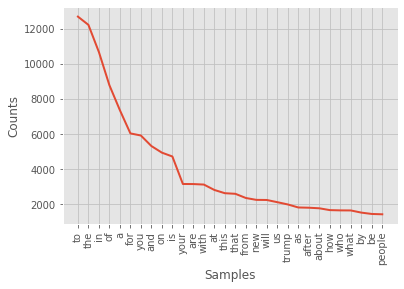

Current Vocab size is = 35624


In [6]:
title_cleaned = graph.get_vocab_length(df.title_cleaned)

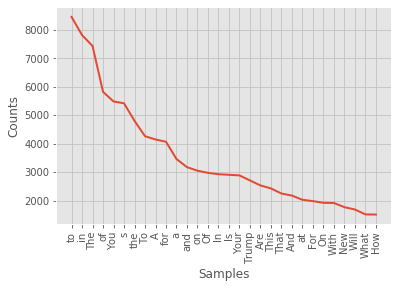

Current Vocab size is = 42185


In [7]:
title_dict= graph.get_vocab_length(df.title)

In [8]:
# Remove stopwords 
df.title_cleaned = df.title_cleaned.apply(pp.remove_stopwords)
df.title_cleaned

0        bill changing credit card rules sent gun measu...
1                  hollywood easymoney generation toughens
2        1700 runners still unaccounted uks lake distri...
3        yankees pitchers trade fielding drills putting...
4        large earthquake rattles indonesia seventh two...
                               ...                        
51533    nbc news video see brazil soccer team pilots f...
51534                  politico scoop eric killed two deer
51535    frenchs forest high school may relocate make w...
51536    los angeles rams jeff fisher may think danny w...
51537    seattle seahawks richard sherman says karma ca...
Name: title_cleaned, Length: 51538, dtype: object

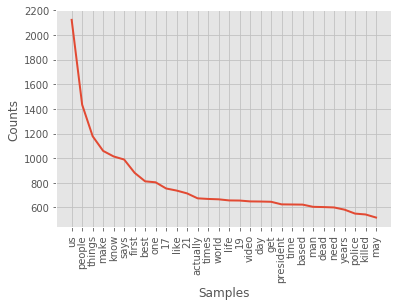

Current Vocab size is = 35483


In [9]:
title_cleaned = graph.get_vocab_length(df.title_cleaned)

In [10]:
df['title_cleaned_lem'] = df.title_cleaned.apply(pp.lemmetise)

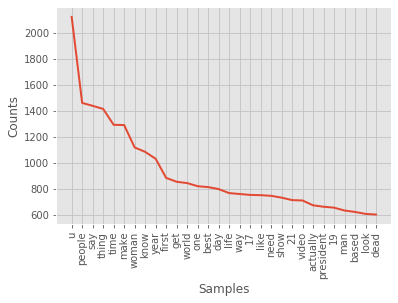

Current Vocab size is = 31225


In [11]:
title_cleaned_lem = graph.get_vocab_length(df.title_cleaned_lem)

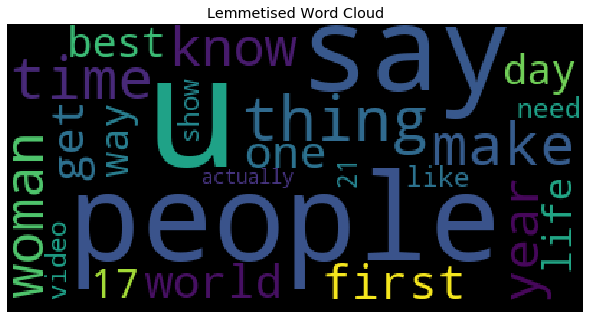

In [14]:
graph.show_wordcloud(title_cleaned_lem, title="Lemmetised Word Cloud")

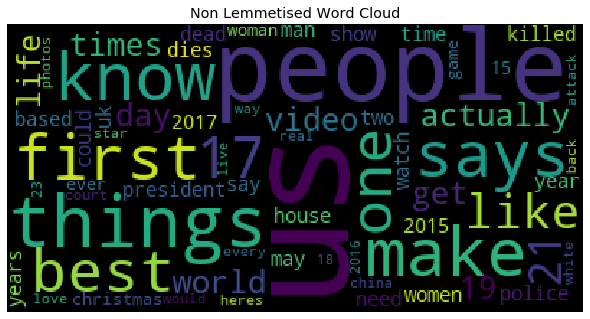

In [15]:
graph.show_wordcloud(title_cleaned, title="Non Lemmetised Word Cloud")

It looks like Lemmetiser will reduce "US" down to u. Which for our purposes is absolutely fine. we reduced the number of words in our corpus from 42k down to 31k. I think that we are now in a position to train test split and run a simple model on the data